In [1]:
%%capture
# Install scQuint
!pip install -U git+https://github.com/songlab-cal/scquint.git

In [2]:
%%capture
# Download processed intron count data
!wget https://figshare.com/ndownloader/files/27696714 -O adata_spl.h5ad

In [3]:
%%capture
# Download gene annotation
!wget --no-check-certificate https://ftp.ensembl.org/pub/release-102/gtf/mus_musculus/Mus_musculus.GRCm38.102.chr.gtf.gz

In [4]:
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
from umap import UMAP

from scquint.data import add_gene_annotation, group_introns, filter_min_cells_per_feature, filter_min_cells_per_intron_group, calculate_PSI
from scquint.differential_splicing import run_differential_splicing
from scquint.dimensionality_reduction.pca import run_pca

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Load preprocessed intron counts
adata = anndata.read_h5ad("adata_spl.h5ad")

# These steps only needed because this data was prepared with older code
adata.var = adata.var[["chromosome", "start", "end", "strand", "annotated"]]
adata.var.end -= 1  # to match the coordinates from this gene annotation
adata.var.index = adata.var.chromosome.astype(str) + ":" + adata.var.start.astype(str) + "-" + adata.var.end.astype(str)
adata = add_gene_annotation(adata, "Mus_musculus.GRCm38.102.chr.gtf.gz")
adata = group_introns(adata, by="three_prime")

adata

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  


Filtering to introns associated to 1 and only 1 gene.


/global/scratch/projects/fc_songlab/gbenegas/projects/scquint/scquint/data.py:126: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_id"] = adata.var.gene_id_list


Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/generic.py:5516: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 44518 × 29924
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'cell_type', 'plate_id'
    var: 'chromosome', 'start', 'end', 'strand', 'annotated', 'gene_id_start', 'gene_id_end', 'n_genes', 'gene_id', 'gene_name', 'intron_group', 'intron_group_size', 'n_genes_per_intron_group'

In [6]:
# Metadata associated to each cell
adata.obs

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,tissue,n_genes,n_counts,louvain,leiden,cell_type,plate_id
my_id,,,,,,,,,,,,,,,,,
A10_B000126,NaN,3m,A10.B000126.3_39_F.1.1,bulge keratinocyte,CL:0002337,nan,facs,3_39_F,female,Telogen,Skin,2552,339047.0,10,9,bulge_keratinocyte,B000126
A10_B000127,NaN,3m,A10.B000127.3_38_F.1.1,myeloid cell,CL:0000763,nan,facs,3_38_F,female,Fat,SCAT,1785,254953.0,16,16,myeloid_cell,B000127
A10_B000166,NaN,3m,A10.B000166.3_56_F.1.1,basal cell,CL:0000646,basal cell,facs,3_56_F,female,Mammary_Gland,Mammary_Gland,4713,2246909.0,22,20,basal_cell,B000166
A10_B000610,NaN,3m,A10.B000610.3_56_F.1.1,bladder urothelial cell,CL:1001428,nan,facs,3_56_F,female,nan,Bladder,4182,1486054.0,28,26,bladder_urothelial_cell,B000610
A10_B000633,NaN,3m,A10.B000633.3_56_F.1.1,endothelial cell of coronary artery,CL:0000115,coronary vascular endothelial cell,facs,3_56_F,female,RV,Heart,2001,448241.0,3,3,endothelial_cell_of_coronary_artery,B000633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9_MAA001887,NaN,3m,P9.MAA001887.3_39_F.1.1,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,female,KLS,Marrow,2919,227378.0,8,8,hematopoietic_stem_cell,MAA001887
P9_MAA001888,NaN,3m,P9.MAA001888.3_39_F.1.1,"CD4-positive, alpha-beta T cell",CL:0000815,BM CD4 T cell,facs,3_39_F,female,T-cells,Marrow,1960,171978.0,7,7,"CD4_positive,_alpha_beta_T_cell",MAA001888
P9_MAA001889,NaN,3m,P9.MAA001889.3_38_F.1.1,B cell,CL:0000236,B,facs,3_38_F,female,EPCAM,Lung,1622,427794.0,1,1,B_cell,MAA001889


In [7]:
# Metadata associated to each intron/splice junction
adata.var

,chromosome,start,end,strand,annotated,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group
Sox17_chr1:4492669-4493099,chr1,4492669,4493099,-,True,ENSMUSG00000025902,ENSMUSG00000025902,1,ENSMUSG00000025902,Sox17,Sox17_chr1_4492669_-,2,1
Sox17_chr1:4492669-4493771,chr1,4492669,4493771,-,True,ENSMUSG00000025902,ENSMUSG00000025902,1,ENSMUSG00000025902,Sox17,Sox17_chr1_4492669_-,2,1
Mrpl15_chr1:4774517-4776409,chr1,4774517,4776409,-,False,ENSMUSG00000033845,,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4774517_-,2,1
Mrpl15_chr1:4774517-4777524,chr1,4774517,4777524,-,True,ENSMUSG00000033845,ENSMUSG00000033845,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4774517_-,2,1
Mrpl15_chr1:4777649-4778747,chr1,4777649,4778747,-,False,ENSMUSG00000033845,,1,ENSMUSG00000033845,Mrpl15,Mrpl15_chr1_4777649_-,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Arhgap6_chrX:169036867-169220197,chrX,169036867,169220197,+,True,ENSMUSG00000031355,ENSMUSG00000031355,1,ENSMUSG00000031355,Arhgap6,Arhgap6_chrX_169220197_+,2,1
Mid1_chrX:169685373-169926953,chrX,169685373,169926953,+,True,ENSMUSG00000035299,ENSMUSG00000035299,1,ENSMUSG00000035299,Mid1,Mid1_chrX_169926953_+,2,1
Mid1_chrX:169879910-169926953,chrX,169879910,169926953,+,True,ENSMUSG00000035299,ENSMUSG00000035299,1,ENSMUSG00000035299,Mid1,Mid1_chrX_169926953_+,2,1
Eif2s3y_chrY:1012170-1014633,chrY,1012170,1014633,+,True,ENSMUSG00000069049,ENSMUSG00000069049,1,ENSMUSG00000069049,Eif2s3y,Eif2s3y_chrY_1014633_+,2,1


In [8]:
# Filtering to heart cells
adata = adata[adata.obs.tissue=="Heart"]
adata = filter_min_cells_per_feature(adata, 100)
adata = filter_min_cells_per_intron_group(adata, 100)
adata.shape

filter_min_cells_per_feature
filter_singletons
filter_min_cells_per_intron_group
filter_singletons


(4433, 3044)

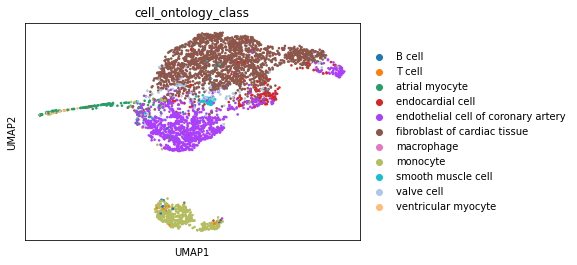

In [9]:
# Obtaining a low dimensional visualization based on alternative splicing
adata.obsm["X_umap"] = UMAP(n_components=2).fit_transform(run_pca(adata, 10))
sc.pl.umap(adata, color='cell_ontology_class')

In [10]:
# Specify the indices of the two groups to be compared
cell_idx_a = np.where(adata.obs.cell_ontology_class=="endocardial cell")[0]
cell_idx_b = np.where(adata.obs.cell_ontology_class=="atrial myocyte")[0]
len(cell_idx_a), len(cell_idx_b)

(164, 159)

In [11]:
intron_groups, introns = run_differential_splicing(
    adata, cell_idx_a, cell_idx_b, min_cells_per_intron_group=50, min_total_cells_per_intron=50, n_jobs=1,
)

  0%|          | 0/82 [00:00<?, ?it/s]

sample sizes:  164 159
(323, 3044)
filter_min_cells_per_feature
filter_singletons
(323, 265)
filter_min_global_proportion
filter_singletons
(323, 265)
filter_min_cells_per_intron_group
filter_singletons
filter_min_cells_per_intron_group
filter_singletons
(323, 165)
Number of intron groups:  82
Number of introns:  165


100%|██████████| 82/82 [00:04<00:00, 17.94it/s]


In [12]:
# information about all the intron groups that were tested
intron_groups

,p_value,ll_null,ll,n_classes,gene_id,gene_name,max_abs_delta_psi,max_abs_lfc_psi,ranking,p_value_adj
intron_group,,,,,,,,,,
Slc25a3_chr10_91119707_-,2.783505e-47,-358.71158349144565,-254.41451957203725,2,ENSMUSG00000061904,Slc25a3,0.803164,29.571781,0,2.282474e-45
Tpm1_chr9_67036129_-,5.241887e-41,-304.4620056272593,-214.54001975381018,2,ENSMUSG00000032366,Tpm1,0.803828,3.785967,1,2.149174e-39
Atp5c1_chr2_10056162_-,4.590732e-39,-452.07306917411984,-366.5985306648096,2,ENSMUSG00000025781,Atp5c1,0.723182,2.771993,2,1.254800e-37
Vdac3_chr8_22583737_-,1.121661e-36,-250.61923551606787,-170.6105698577963,2,ENSMUSG00000008892,Vdac3,0.798089,6.172689,3,2.299405e-35
Myl6_chr10_128491034_-,1.332322e-29,-843.9144475995784,-780.084564354692,2,ENSMUSG00000090841,Myl6,0.560651,1.895847,4,2.185008e-28
...,...,...,...,...,...,...,...,...,...,...
Atp5g3_chr2_73911061_-,8.684012e-01,-285.018287649314,-285.00456111069207,2,ENSMUSG00000018770,Atp5g3,0.010470,0.036641,77,9.028508e-01
Cd47_chr16_49884164_+,8.698196e-01,-319.71412683400314,-319.70069726538645,2,ENSMUSG00000055447,Cd47,0.007564,0.057573,78,9.028508e-01
Sqstm1_chr11_50200948_-,9.347043e-01,-377.83197645534915,-377.82862038896303,2,ENSMUSG00000015837,Sqstm1,0.003533,0.025456,79,9.580719e-01


In [13]:
# information about all the introns corresponding to the tested intron groups
introns

,chromosome,start,end,strand,annotated,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group,psi_a,psi_b,delta_psi,lfc_psi,abs_delta_psi,abs_lfc_psi
index,,,,,,,,,,,,,,,,,,,
Slc25a3_chr10:91119707-91121921,chr10,91119707,91121921,-,True,ENSMUSG00000061904,ENSMUSG00000061904,1,ENSMUSG00000061904,Slc25a3,Slc25a3_chr10_91119707_-,2,1,1.000000e+00,0.196836,0.803164,2.344936,0.803164,2.344936
Slc25a3_chr10:91119707-91122206,chr10,91119707,91122206,-,True,ENSMUSG00000061904,ENSMUSG00000061904,1,ENSMUSG00000061904,Slc25a3,Slc25a3_chr10_91119707_-,2,1,6.494020e-12,0.803164,-0.803164,-29.571781,0.803164,29.571781
Myl6_chr10:128491034-128491719,chr10,128491034,128491719,-,True,ENSMUSG00000090841,ENSMUSG00000090841,1,ENSMUSG00000090841,Myl6,Myl6_chr10_128491034_-,3,1,7.666660e-01,0.206015,0.560651,1.895847,0.560651,1.895847
Myl6_chr10:128491034-128492058,chr10,128491034,128492058,-,True,ENSMUSG00000090841,ENSMUSG00000090841,1,ENSMUSG00000090841,Myl6,Myl6_chr10_128491034_-,3,1,2.333340e-01,0.793985,-0.560651,-1.766715,0.560651,1.766715
Uqcr10_chr11:4702221-4703903,chr11,4702221,4703903,-,True,ENSMUSG00000059534,ENSMUSG00000059534,1,ENSMUSG00000059534,Uqcr10,Uqcr10_chr11_4702221_-,4,1,3.145444e-02,0.102419,-0.070964,-1.703142,0.070964,1.703142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bnip2_chr9:70004342-70007063,chr9,70004342,70007063,+,True,ENSMUSG00000011958,ENSMUSG00000011958,1,ENSMUSG00000011958,Bnip2,Bnip2_chr9_70007063_+,2,1,3.856290e-01,0.866008,-0.480379,-1.167167,0.480379,1.167167
Rpl29_chr9:106429577-106429969,chr9,106429577,106429969,+,True,ENSMUSG00000048758,ENSMUSG00000048758,1,ENSMUSG00000048758,Rpl29,Rpl29_chr9_106429969_+,3,1,8.472850e-01,0.814178,0.033107,0.057502,0.033107,0.057502
Rpl29_chr9:106429640-106429969,chr9,106429640,106429969,+,True,ENSMUSG00000048758,ENSMUSG00000048758,1,ENSMUSG00000048758,Rpl29,Rpl29_chr9_106429969_+,3,1,1.527150e-01,0.185822,-0.033107,-0.283076,0.033107,0.283076


In [14]:
# Number of significant differential splicing events
(intron_groups.p_value_adj < 0.05).sum()

43

In [15]:
# The introns belonging to the intron group with the lowest p-value
introns[introns.intron_group=="Slc25a3_chr10_91119707_-"]

,chromosome,start,end,strand,annotated,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,intron_group,intron_group_size,n_genes_per_intron_group,psi_a,psi_b,delta_psi,lfc_psi,abs_delta_psi,abs_lfc_psi
index,,,,,,,,,,,,,,,,,,,
Slc25a3_chr10:91119707-91121921,chr10,91119707,91121921,-,True,ENSMUSG00000061904,ENSMUSG00000061904,1,ENSMUSG00000061904,Slc25a3,Slc25a3_chr10_91119707_-,2,1,1.000000e+00,0.196836,0.803164,2.344936,0.803164,2.344936
Slc25a3_chr10:91119707-91122206,chr10,91119707,91122206,-,True,ENSMUSG00000061904,ENSMUSG00000061904,1,ENSMUSG00000061904,Slc25a3,Slc25a3_chr10_91119707_-,2,1,6.494020e-12,0.803164,-0.803164,-29.571781,0.803164,29.571781


In [16]:
# Calculate PSI (intron proportions) from intron counts
# This will contain lots of nan's
adata.layers["PSI_raw"] = calculate_PSI(adata)

/global/scratch/projects/fc_songlab/gbenegas/projects/scquint/scquint/data.py:200: RuntimeWarning: invalid value encountered in true_divide
  return X / intron_group_sums[:,groups]


In [17]:
# Select 1 intron from each of the top-10 differentially spliced intron groups
introns.intron_group = introns.intron_group.astype(str)
introns = introns[introns.abs_delta_psi > 0.1]
introns_to_plot = introns[introns.intron_group.isin(intron_groups.head(10).index)].groupby("intron_group").sample(n=1, random_state=42).sort_values("delta_psi").index

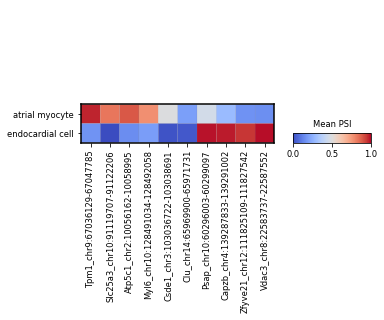

In [18]:
sc.pl.matrixplot(
    adata[adata.obs.cell_ontology_class.isin(["endocardial cell", "atrial myocyte"])],
    introns_to_plot,
    'cell_ontology_class',
    vmin=0,
    vmax=1,
    cmap="coolwarm",
    layer="PSI_raw",
    colorbar_title="Mean PSI"
)

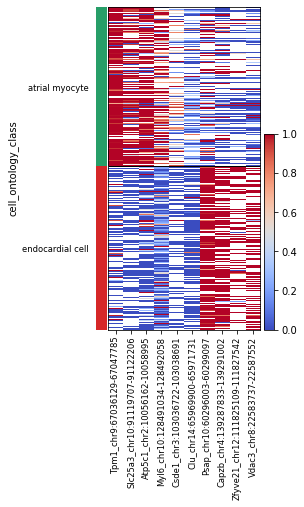

In [19]:
sc.pl.heatmap(
    adata[adata.obs.cell_ontology_class.isin(["endocardial cell", "atrial myocyte"])],
    introns_to_plot,
    'cell_ontology_class',
    layer="PSI_raw",
    vmin=0,
    vmax=1,
    cmap="coolwarm",
)

In [20]:
# The results can be further visualized with 
# the cellxgene browser https://scquint.ds.czbiohub.org/tabula-muris/
# and UCSC Genome Browser https://genome.ucsc.edu/s/gbenegas/tabulamuris